# **MultiLayer Perceptron - MLP**

OBJETIVOS:
- Implementação da MLP - código base: https://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera/tree/master/Neural%20Networks%20and%20Deep%20Learning/week4
- Implementação da regularização L2 com o objetivo de otimizar o desempenho da MLP. 
- Variação dos parâmetros: learning_rate, num_iterations e lambda, de modo a verificar o modelo com melhor acurácia.

In [ ]:
# Importação das bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [ ]:
# Definição da função de ativação sigmoide = 1/(1+e(-x))
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z   
    return A, cache

# Definição da função de ativação relu = max(0,x)
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

# Definição da derivada da função de ativação relu
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0 # when z<=0, you should set dz to 0 as well. 
    return dZ

# Definição da derivada da função de ativação sigmoide
def sigmoid_backward(dA, cache):
    Z = cache   
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

# **SEM REGULARIZAÇÃO L2** 

In [ ]:
# Definindo a seed
np.random.seed(1)

def load_dataset():
    '''
    Carrega os arquivos train_catvnoncat e test_catvnoncat
    Separa em (train e test) e (features e labels)
    '''
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes   
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters_deep(layer_dims):
    '''
    Inicializa pesos = aleatório e bias = 1
    Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network
    Returns:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    '''
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)    # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))        
    return parameters


def linear_forward(A, W, b):
    ''' 
    Implementa a parte linear da propagação direta de uma camada
    Arguments:
      A -- activations from previous layer (or input data): (size of previous layer, number of examples)
      W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
      b -- bias vector, numpy array of shape (size of the current layer, 1)
    Returns:
      Z -- the input of the activation function
    '''
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    '''
    Implementa a propagação direta para a camada LINEAR-> ATIVAÇÃO
    Arguments:
      A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
      W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
      b -- bias vector, numpy array of shape (size of the current layer, 1)
      activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    Returns:
      A -- the output of the activation function
    '''
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)    
    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters):
    '''
    Implementa a propagação direta para o cálculo [LINEAR-> RELU] * (L-1) -> LINEAR-> SIGMOID
    Arguments:
      X -- data, numpy array of shape (input size, number of examples)
      parameters -- output of initialize_parameters_deep()
    Returns:
      AL -- last post-activation value
    '''
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1)  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    # Implement LINEAR -> SIGMOID
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = "sigmoid")
    caches.append(cache)    
    return AL, caches


def compute_cost(AL, Y):
    '''
    Implementa a função de custo
    Arguments:
      AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
      Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
      cost -- cross-entropy cost
    '''
    m = Y.shape[1]
    cost = (-1/m) * np.sum( np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T) )    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).  
    return cost


def linear_backward(dZ, cache):
    '''
    Implementa a parte linear da backpropagation para uma única camada
    Arguments:
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    Returns:
      dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
      dW -- Gradient of the cost with respect to W (current layer l), same shape as W
     db -- Gradient of the cost with respect to b (current layer l), same shape as b
    '''
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    '''
    Implementa a backpropagation para a camada LINEAR-> ATIVAÇÃO
    Arguments:
      dA -- post-activation gradient for current layer l
      cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
      activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    Returns:
      dA_prev -- Gradient of the cost with respect to the activation (of the prchroevious layer l-1), same shape as A_prev
      dW -- Gradient of the cost with respect to W (current layer l), same shape as W
      db -- Gradient of the cost with respect to b (current layer l), same shape as b
    '''
    linear_cache, activation_cache = cache    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    '''
    Implementa a backpropagation para o grupo [LINEAR-> RELU] * (L-1) -> LINEAR -> SIGMOID
    Arguments:
      AL -- probability vector, output of the forward propagation (L_model_forward())
      Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
      caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    Returns:
      grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    '''
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL 
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads


def update_parameters(parameters, grads, learning_rate):   
    '''
    Atualiza parâmetros usando gradiente descendente
    Arguments:
      parameters -- python dictionary containing your parameters
      grads -- python dictionary containing your gradients, output of L_model_backward
    Returns:
      parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    '''
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L): 
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]       
    return parameters


def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, lamb = 0.5, print_cost=False):#lr was 0.009
    '''
    Implementa uma rede neural de L camadas: [LINEAR-> RELU] * (L-1) -> LINEAR-> SIGMOID
    Arguments:
      X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
      Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
      layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
      learning_rate -- learning rate of the gradient descent update rule
      num_iterations -- number of iterations of the optimization loop
      print_cost -- if True, it prints the cost every 100 steps
    Returns:
      parameters -- parameters learnt by the model. They can then be used to predict.
    '''
    np.random.seed(1)
    costs = []                    
    # Parameters initialization   
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters)  

        # Compute cost    
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = L_model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate) 

        # Print the cost every 100 training example             
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


def predict(X, y, parameters):   
    '''
    Previsão dos resultados de uma rede neural de L camadas
    Arguments:
      X -- data set of examples you would like to label
      parameters -- parameters of the trained model
    Returns:
      p -- predictions for the given dataset X
    ''' 
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))   

    # Forward propagation
    probas, _ = L_model_forward(X, parameters)  

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    print("Accuracy: "  + str(np.sum((p == y)/m)))        
    return p

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


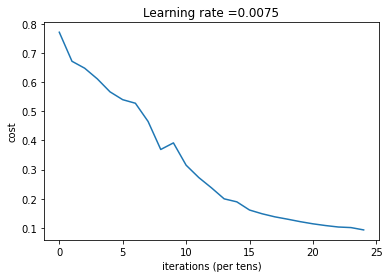

Train:
Accuracy: 0.9856459330143539
Test:
Accuracy: 0.8


In [ ]:
# Carregando os datasets
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

# Transformando dimensão do conjunto de treino e teste 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Padronizando os dados para valores entre 0 e 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

# Definindo o modelo
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = True)

# Imprimindo o resultado
print("Train:")
predictions_train = predict(train_x, train_y, parameters)
print("Test:")
predictions_test = predict(test_x, test_y, parameters)

# **RESULTADOS SEM REGULARIZAÇÃO:**
Com learning_rate = 0.0075 e num_iterations = 2500 a acurácia foi:
- Accuracy train: 0.9856459330143539
- Accuracy test: 0.8

# **COM REGULARIZAÇÃO L2** 

In [ ]:
# Definindo a seed
np.random.seed(1)

def load_dataset():
    '''
    Carrega os arquivos train_catvnoncat e test_catvnoncat
    Separa em (train e test) e (features e labels)
    '''
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes   
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters_deep(layer_dims):
    '''
    Inicializa pesos = aleatório e bias = 1
    Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network
    Returns:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    '''
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)    # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))        
    return parameters


def linear_forward(A, W, b):
    ''' 
    Implementa a parte linear da propagação direta de uma camada
    Arguments:
      A -- activations from previous layer (or input data): (size of previous layer, number of examples)
      W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
      b -- bias vector, numpy array of shape (size of the current layer, 1)
    Returns:
      Z -- the input of the activation function
    '''
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    '''
    Implementa a propagação direta para a camada LINEAR-> ATIVAÇÃO
    Arguments:
      A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
      W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
      b -- bias vector, numpy array of shape (size of the current layer, 1)
      activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    Returns:
      A -- the output of the activation function
    '''
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)    
    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters):
    '''
    Implementa a propagação direta para o cálculo [LINEAR-> RELU] * (L-1) -> LINEAR-> SIGMOID
    Arguments:
      X -- data, numpy array of shape (input size, number of examples)
      parameters -- output of initialize_parameters_deep()
    Returns:
      AL -- last post-activation value
    '''
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1)  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    # Implement LINEAR -> SIGMOID
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = "sigmoid")
    caches.append(cache)    
    return AL, caches


def compute_cost(AL, Y):
    '''
    Implementa a função de custo
    Arguments:
      AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
      Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
      cost -- cross-entropy cost
    '''
    m = Y.shape[1]
    cost = (-1/m) * np.sum( np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T) )    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).  
    return cost


def linear_backward(dZ, cache):
    '''
    Implementa a parte linear da backpropagation para uma única camada
    Arguments:
      dZ -- Gradient of the cost with respect to the linear output (of current layer l)
      cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    Returns:
      dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
      dW -- Gradient of the cost with respect to W (current layer l), same shape as W
     db -- Gradient of the cost with respect to b (current layer l), same shape as b
    '''
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    '''
    Implementa a backpropagation para a camada LINEAR-> ATIVAÇÃO
    Arguments:
      dA -- post-activation gradient for current layer l
      cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
      activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    Returns:
      dA_prev -- Gradient of the cost with respect to the activation (of the prchroevious layer l-1), same shape as A_prev
      dW -- Gradient of the cost with respect to W (current layer l), same shape as W
      db -- Gradient of the cost with respect to b (current layer l), same shape as b
    '''
    linear_cache, activation_cache = cache    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache) 
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    '''
    Implementa a backpropagation para o grupo [LINEAR-> RELU] * (L-1) -> LINEAR -> SIGMOID
    Arguments:
      AL -- probability vector, output of the forward propagation (L_model_forward())
      Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
      caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    Returns:
      grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    '''
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL 
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads


def update_parameters(X, parameters, grads, learning_rate, lamb):   
    '''
    Atualiza parâmetros usando gradiente descendente
    Arguments:
      X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
      parameters -- python dictionary containing your parameters
      grads -- python dictionary containing your gradients, output of L_model_backward
      learning_rate -- learning rate of the gradient descent update rule
      lamb -- lamda: L2 regularization
    Returns:
      parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    '''
    L = len(parameters) // 2 # number of layers in the neural network
    m = X.shape[1]

    # Update rule for each parameter. Use a for loop.
    for l in range(L): #com regularization l2
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * lamb * parameters["W" + str(l+1)]/(2*m) - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]      
    return parameters


def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, lamb = 0.5, print_cost=False):#lr was 0.009
    '''
    Implementa uma rede neural de L camadas: [LINEAR-> RELU] * (L-1) -> LINEAR-> SIGMOID
    Arguments:
      X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
      Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
      layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
      learning_rate -- learning rate of the gradient descent update rule
      num_iterations -- number of iterations of the optimization loop
      print_cost -- if True, it prints the cost every 100 steps
    Returns:
      parameters -- parameters learnt by the model. They can then be used to predict.
    '''
    np.random.seed(1)
    costs = []                    
    # Parameters initialization   
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters)  

        # Compute cost    
        cost = compute_cost(AL, Y)

        # Backward propagation
        grads = L_model_backward(AL, Y, caches)

        # Update parameters
        parameters = update_parameters(X, parameters, grads, learning_rate, lamb) 

        # Print the cost every 100 training example             
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


def predict(X, y, parameters):   
    '''
    Previsão dos resultados de uma rede neural de L camadas
    Arguments:
      X -- data set of examples you would like to label
      parameters -- parameters of the trained model
    Returns:
      p -- predictions for the given dataset X
    ''' 
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))   

    # Forward propagation
    probas, _ = L_model_forward(X, parameters)  

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    print("Accuracy: "  + str(np.sum((p == y)/m)))        
    return p

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672097
Cost after iteration 200: 0.646818
Cost after iteration 300: 0.609343
Cost after iteration 400: 0.564448
Cost after iteration 500: 0.569493
Cost after iteration 600: 0.466507
Cost after iteration 700: 0.463403
Cost after iteration 800: 0.388323
Cost after iteration 900: 0.330517
Cost after iteration 1000: 0.263441
Cost after iteration 1100: 0.263524
Cost after iteration 1200: 0.223266
Cost after iteration 1300: 0.188250
Cost after iteration 1400: 0.160406
Cost after iteration 1500: 0.140377
Cost after iteration 1600: 0.126555
Cost after iteration 1700: 0.113872
Cost after iteration 1800: 0.103356
Cost after iteration 1900: 0.095677
Cost after iteration 2000: 0.088349
Cost after iteration 2100: 0.082132
Cost after iteration 2200: 0.077046
Cost after iteration 2300: 0.074257
Cost after iteration 2400: 0.068199
Cost after iteration 2500: 0.065663
Cost after iterati

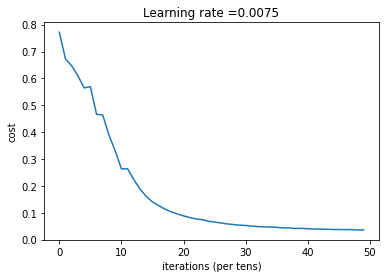

Train:
Accuracy: 0.9952153110047844
Test:
Accuracy: 0.8400000000000001


In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

# Definindo o modelo
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 5000, lamb = 2, print_cost = True)

# Imprimindo o resultado
print("Train:")
predictions_train = predict(train_x, train_y, parameters)
print("Test:")
predictions_test = predict(test_x, test_y, parameters)

# **RESULTADOS COM REGULARIZAÇÃO:**


##Modificando a learning rate para: 0.0075, 0.0005, 0.009 e 0.007
##Fixos: num_iterations = 3000 e lamb = 2

parameters: learning_rate = 0.0075, num_iterations = 3000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8200000000000001

parameters: learning_rate = 0.0005, num_iterations = 3000, lamb = 2
- Accuracy train:0.7990430622009568
- Accuracy test: 0.5

parameters: learning_rate = 0.009, num_iterations = 3000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8

parameters: learning_rate = 0.007, num_iterations = 3000, lamb = 2
- Accuracy train:: 0.9952153110047846
- Accuracy test: 0.78

Após variar o valor da learning rate, notou-se que ao aumentar muito seu valor, a acurácia diminuiu. Da mesma forma, ao diminuir o valor da larning rate a acurácia também diminuiu. Portanto, fixou-se a learning rate em 0.0075 que tem a melhor acurácia.

##Modificando a lambda para: 0.5, 1 , 2 e 3
##Fixos: learning_rate = 0.0075 e num_iterations = 3000

parameters: learning_rate = 0.0075, num_iterations = 3000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8200000000000001

parameters: learning_rate = 0.0075, num_iterations = 3000, lamb = 3
- Accuracy train: 0.9999999999999998
- Accuracy test: 0.76

parameters: learning_rate = 0.0075, num_iterations = 3000, lamb = 1
- Accuracy train:0.9856459330143539
- Accuracy test: 0.8200000000000001

parameters: learning_rate = 0.0075, num_iterations = 3000, lamb = 0.5
- Accuracy train: 0.9904306220095691
- Accuracy test: 0.76

Após variar o valor do lambda, notou-se que os valores de lambda = 1 ou 2 possuem melhores valores da acurácia. Portanto, fixou-se a lambda em 2.

##Modificando o num de interações para: 3500, 4000, 5000 e 10000
##Fixos: learning_rate = 0.0075 e lamb = 2

parameters: learning_rate = 0.0075, num_iterations = 3500, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8200000000000001

parameters: learning_rate = 0.0075, num_iterations = 4000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8200000000000001

parameters: learning_rate = 0.0075, num_iterations = 5000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8400000000000001

parameters: learning_rate = 0.0075, num_iterations = 10000, lamb = 2
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8200000000000001

Por último, o número de interações foi variado e notou-se que o valor de 5000 interações possui melhor acurácia. Portanto o modelo final permaneceu com os seguintes parâmetros: learning_rate = 0.0075, num_iterations = 5000 e lamb = 2 

Melhor acurácia:
- Accuracy train: 0.9952153110047844
- Accuracy test: 0.8400000000000001